# Cleaning Modes With Rational Filters

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
from joblib import Parallel, delayed
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import sys

## GW150914

Download data

In [15]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

In [16]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147+2.0*1e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [17]:
fit.import_ligo_data('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5')
fit.import_ligo_data('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5')

Perform time alignment across detectors

In [18]:
fit.detector_alignment(**input)

Condition data 

In [19]:
fit.condition_data('oringal_data', **input)

Cholesky-decomposition of the covariance matrix 

In [20]:
fit.compute_acfs()
fit.cholesky_decomposition()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [21]:
chispace = np.arange(0.0, 0.95, 0.06)
massspace = np.arange(34, 100, 2.0)
X, Y = np.meshgrid(massspace, chispace)

Interate over the samplings

In [22]:
finalfinal = []
for j in chispace:
    #A silly way to parallelize...
    final = Parallel(-1)(delayed(fit.likelihood_vs_mass_spin)(i, j, **input) 
                         for i in massspace)
    finalfinal.append(final)

    #print the process
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %f%%" % ('='*int(20*j/chispace[-1]), 100*j/chispace[-1]))
    sys.stdout.flush()
    
finalfinal = np.array(finalfinal)

[====================] 100.000000%

Plot 2d contours

Text(0, 0.5, '$\\chi_f$')

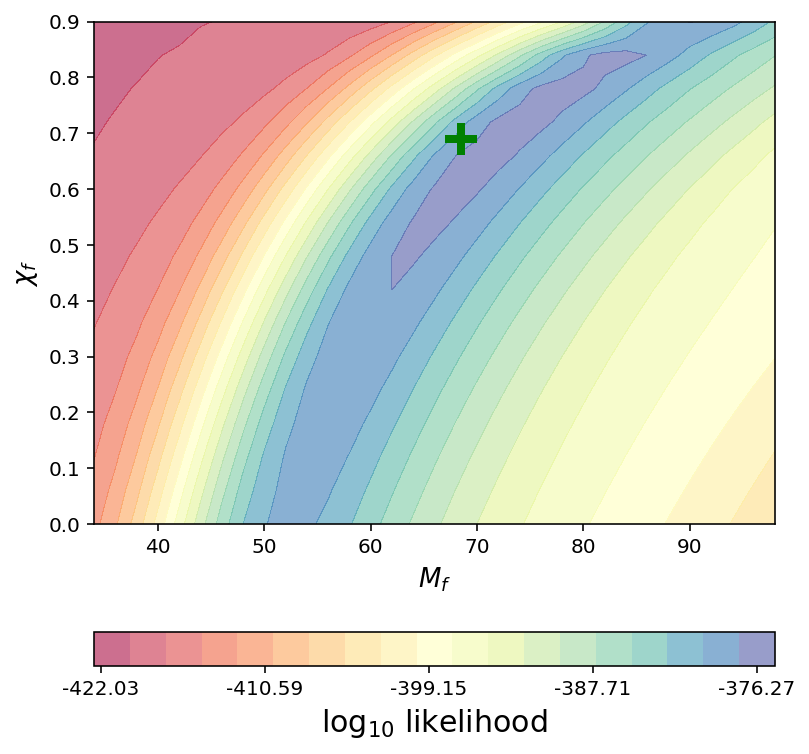

In [23]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(X, Y, finalfinal, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\log_{10}$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(finalfinal), np.max(finalfinal), 5))

pl.xlabel(r'$M_f$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')